In [1]:
import models.models_one_task as md_one
import datasets.iemocap as ds
from datasets.ramas import RamasDataset
from constants import *
from torchsummary import summary
import torch
import torch.nn as nn
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from skorch.classifier import NeuralNetClassifier
import skorch.callbacks as callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [3]:
def create_results_file(net, name):
    dfs_list = []
    for metric in ['accuracy', 'loss']:
        _dfs_list = []
        for subset in ['train', 'test']:
            results = net.history[:, f'{subset}_{metric}']
            df = pd.DataFrame(results, columns=['result'])
            df['epochs'] = np.arange(1, len(results) + 1)
            df['subset'] = subset
            _dfs_list.append(df)
        df = pd.concat(_dfs_list, ignore_index=True)
        df['metric'] = metric
        dfs_list.append(df)
    final_df = pd.concat(dfs_list, ignore_index=True)
    final_df.to_csv(os.path.join(RESULTS_FOLDER, f'{name}__result.csv'), sep=';', index=False)

# Описание и демонстрация модулей

# Модуль models_one_task 

Модуль models_one_task на данный момент содержит PyTorch имплементацию следующих моделей для однозадачного обучения:

## AlexNet

[Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. <i>Commun. ACM</i> 60, 6 (June 2017), 84–90. DOI:https://doi.org/10.1145/3065386]

Архитектура немного переделана, чтобы соответствовать нашей специфике:<br>
1. Количество входных каналов первого сверточного слоя уменьшено с 3 до 1
2. Изменён последний свёрточный слой, его ядро увеличено с (3, 3) до (4, 4)
3. Изменён слой AdaptiveAvgPool2d с (6, 6) до (5, 5)
4. Изменён классификатор, теперь это четыре полносвязных слоя: 6400, 2048, 512, <число классов>
5. Добавлен Dropout() после первого и второго полносвязного слоя

In [7]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(device)
print(model)
summary(model, (1, 224, 224), batch_size=128)
model=None
torch.cuda.empty_cache()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
 

## VGG

[Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. ]

Архитектура классификатора переделана в схожей с AlexNet манере.

In [5]:
# type - тип модели (11, 16, 19)
# bn - batch norm
model = md_one.vgg(num_classes=4, type=11, bn=False)
model = model.to(device)
print(model)
summary(model, (1, 224, 224), batch_size=64)
model=None
torch.cuda.empty_cache()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## SER DeepNet

[Anvarjon, T.; Mustaqeem; Kwon, S. Deep-Net: A Lightweight CNN-Based Speech Emotion Recognition System Using Deep Frequency Features. Sensors 2020, 20, 5212.]

У этой архитектуры заявлена точность на четырехклассовом IEMOCAP 77%. Отличается использованием свёртки с ядрами от (11,1) до (1,1), таким образом, свёртка спектрограммы происходит только по частотной оси. <br>
На вход подаются спектрограммы размерности 64х64

In [4]:
model = md_one.PaperCnnDeepNet(num_classes=4)
model = model.to(device)
print(model)
summary(model, (1, 64, 64), batch_size=64)

PaperCnnDeepNet(
  (features): Sequential(
    (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
    (1): ReLU(inplace=True)
    (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (3): ReLU(inplace=True)
    (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (9): ReLU(inplace=True)
    (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(20, 40, kernel_size=(13, 1), stride=(1, 1), padding=(6, 0))
    (15): Re

## SER StrideNet

[., Mustaqeem & Kwon, Soonil. (2019). A CNN-Assisted Enhanced Audio Signal Processing for Speech Emotion Recognition. Sensors. 20. 183. 10.3390/s20010183. ]

Ещё одна архитектура с высокой заявленной точностью.
Особенностью этой архитектуры является отсутствие Pooling слоёв: снижение размерности достигается использованием шага свёртки, равного двум. <br>
На вход подаются спектрограммы размером 128x128

In [14]:
model = md_one.PaperCnnStrideNet(num_classes=4)
model = model.to(device)
print(model)
summary(model, (1, 128, 128), batch_size=64)

PaperCnnStrideNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=True)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


## ResNet

[K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = md_one.resnet34(pretrained=False, progress=True, num_classes=4)
model = model.to(device)
print(model)
summary(model, (1, 224, 224), batch_size=32)
model=None
torch.cuda.empty_cache()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Модуль iemocap

Данный модуль содержит класс IemocapDataset. <br>
При инициализации экземпляра класса, производится попытка считать файл нужного исходя из указанных параметров датасета. 
Если попытка неудачна, будет начат процесс по составлению такого файла. За всеми подробностями добро пожаловать в 
datasets/iemocap.py

## Датасет IEMOCAP

In [12]:
iemocap = ds.IemocapDataset(
    """
    Пути до файлов
    """
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    
    
    """    
    Параметры, по которым будет искаться .pkl-файл датасета. Изменение этих параметров у уже инициализированного экземпляра
    либо не приведет ни к какому результату, либо сломает программу, поэтому если их нужно поменять, то лучше инициализировать
    новый экземпляр
    
    base_name - идентификационное имя
    
    label_type - тип используемой разметки для IEMOCAP: 'four' - четыре класса (ang, hap, neu, sad), 'original' - все классы.
    mode - тренировочный или тестовый набор. Было заранее проведено разделение wav файлов на тренировочный и тестовый наборы
    (см. datasets/train_test_splits.py) c одинаковой взвешенностью эмоциональных классов.
    
    preprocessing - использовать или нет препроцессинг (удаление шума и тишины)
    
    spectrogram_shape - размер спектрограммы. Может быть каким угодно целым, но заранее заготовлены 64, 128 и 224.
    
    spectrogram_type - тип спектрограммы. Может быть 'spec' - обычная, и 'melspec' - мел-спектрограмма.
    """
    base_name='IEMOCAP', label_type='four', mode='train', preprocessing=False, spectrogram_shape=224, spectrogram_type='melspec',
    
    
    """    
    Параметры, влияющие на тип получаемых при индексации данных.
    Эти параметры можно менять у уже инициализированных экземпляров.
    
    augmentation - аугментация тренировочных данных. 
    Если спектрограмма слишком короткая, и augmentation=True, то она подается на функцию аугментации.
    Функция аугментации эту спектрограмму случайным образом может либо дополнить самой собой случайное количество раз 
    (чего может быть недостаточно, поэтому функция организована рекурсивно) либо окружить нулями. Процесс продолжается 
    до тех пор, пока спектрограмма не станет либо нужного размера, либо большего. Спектрограммы большего размера 
    случайно обрезаются. Важно заметить, что аугментации подвергаются только лишь тренировочные данные, тестовые же 
    спектрограммы, если они слишком короткие, обрабатываются одинаково (с фиксированным случайным зерном) в зависимости 
    от значения параметра padding.
    
    padding - обработка слишком коротких спектрограмм.
    Подобным образом обрабатываются все тестовые экземпляры (с фиксированным зерном), а также можно таким образом обработать
    и тренировочные экземпляры (с не фиксированным зерном), если augmentation=False. 
    Возможные варианты: 'zero' - окружить нулями до нужного размера, 'repeat' - повторить саму себя столько раз, 
    сколько необходимо для достижения нужного или большего размера, затем обрезать.
    
    tasks - список задач (tuple). Доступны: 
    emotion; (emotion, speaker); (emotion, gender); (emotion, speaker, gender); (valence, arousal, dominance) 
    """
    augmentation=False, padding='repeat', tasks='emotion' 
)

SyntaxError: invalid syntax (<ipython-input-12-924d8a06020c>, line 5)

### Заранее готовы следующие варианты датасета IEMOCAP:

#### Разметка на 4 эмоциональные категории:

Размер спектрограммы 64х64, с препроцессингом и без, тренировочный и тестовый наборы

In [2]:
iemocap_64_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion'
)
iemocap_64_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion'
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_64_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_64_test ===============
=========================== SUCCESS! ====================================


In [3]:
iemocap_64_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion' 
)
iemocap_64_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=64, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_64_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_64_test ===============
=========================== SUCCESS! ====================================


Размер спектрограммы 128х128, с препроцессингом и без, тренировочный и тестовый наборы

In [2]:
iemocap_128_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)
iemocap_128_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_128_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_128_test ===============
=========================== SUCCESS! ====================================


In [3]:
iemocap_128_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)
iemocap_128_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=128, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_128_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_128_test ===============
=========================== SUCCESS! ====================================


Размер спектрограммы 224х224, с препроцессингом и без, тренировочный и тестовый наборы

In [4]:
iemocap_224_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion'
)
iemocap_224_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion'
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_test ===============
=========================== SUCCESS! ====================================


In [4]:
iemocap_224_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion'
)
iemocap_224_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion' 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_224_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_224_test ===============
=========================== SUCCESS! ====================================


### Метод show_image() позволяет взглянуть, какие спектрограммы выдает датасет в текущей конфигурации. 
#### Возвращает ax - объект Axes. Продемонстрирую с его помощью, как работает аугментация данных на примере тренировочного набора без препроцессинга с четырьмя категориями. Будет выведена четыре раза одна спектрограмма.

In [6]:
img, label = iemocap_224_noprep_train[0]
print(img.shape)

torch.Size([1, 224, 224])


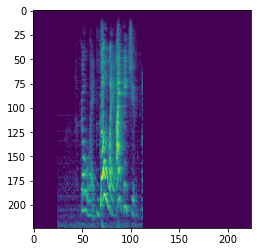

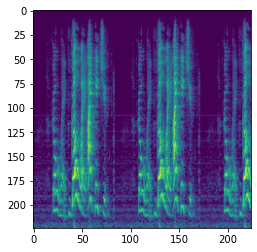

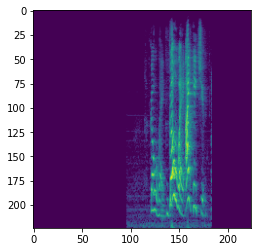

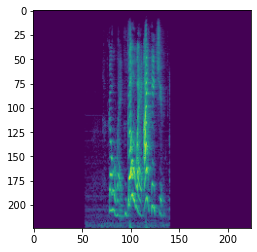

In [12]:
iemocap_224_noprep_train.augmentation = True
np.random.seed()
n = np.random.randint(1, len(iemocap_224_noprep_train))
for i in np.arange(1, 5):
        ax = iemocap_224_noprep_train.show_image(n)
        plt.show()

#### Тестовые спектрограммы ведут себя иначе, они всегда одинаковы
#### Однако, заранее нужно указать для всех будущих спектрограмм тип пэддигна, это небольшой минус

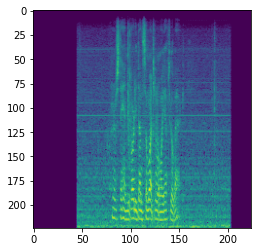

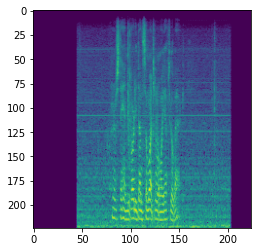

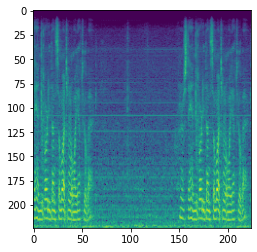

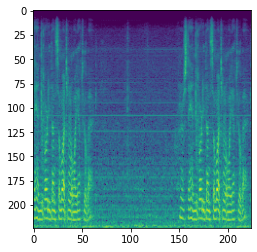

In [13]:
iemocap_224_noprep_test.padding = 'zero'  
np.random.seed()
n = np.random.randint(1, len(iemocap_224_noprep_test))
for i in np.arange(1, 3):
        ax = iemocap_224_noprep_test.show_image(n)
        plt.show()
iemocap_224_noprep_test.padding = 'repeat'
for i in np.arange(1, 3):
        ax = iemocap_224_noprep_test.show_image(n)
        plt.show()

#### Также взглянем на результат препроцессинга

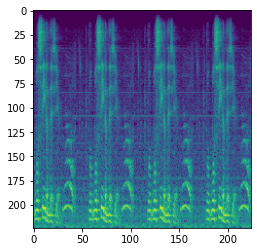

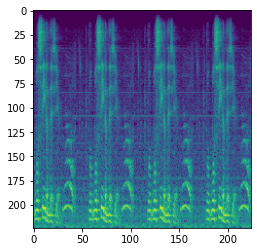

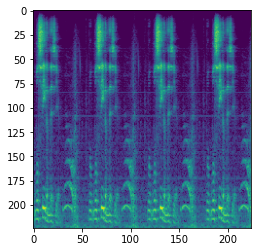

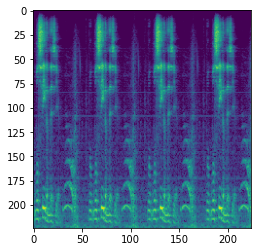

In [17]:
np.random.seed()
n = np.random.randint(1, len(iemocap_224_prep_test))
iemocap_224_prep_test.padding = 'repeat'
iemocap_224_noprep_test.padding = 'repeat'
for i in np.arange(1, 3):
        ax = iemocap_224_noprep_test.show_image(n)
        plt.show()
for i in np.arange(1, 3):
        ax = iemocap_224_prep_test.show_image(n)
        plt.show()

## Датасет RAMAS

Код для инициализации этого датасета находится в datasets/ramas.py. 

In [4]:
ramas_64_train = RamasDataset(wavs_path=RAMAS_PATH_TO_WAVS_DOM_SUB, base_name='RAMAS',  # Тренировочный
                 spectrogram_shape=64,
                 augmentation=False, padding='zero', mode='train', tasks='emotion', emotions=('Domination', 'Submission'))
ramas_64_test = RamasDataset(wavs_path=RAMAS_PATH_TO_WAVS_DOM_SUB, base_name='RAMAS',  # Тестовый
                 spectrogram_shape=64,
                 augmentation=False, padding='zero', mode='test', tasks='emotion', emotions=('Domination', 'Submission'))

============= INITIALIZING DATASET RAMAS_64_train ===============
============================ SUCCESS! =========================
============= INITIALIZING DATASET RAMAS_64_test ===============
============================ SUCCESS! =========================


In [3]:
ramas_128_train = RamasDataset(wavs_path=RAMAS_PATH_TO_WAVS_DOM_SUB, base_name='RAMAS',  # Тренировочный
                 spectrogram_shape=128,
                 augmentation=False, padding='zero', mode='train', tasks='emotion', emotions=('Domination', 'Submission'))
ramas_128_test = RamasDataset(wavs_path=RAMAS_PATH_TO_WAVS_DOM_SUB, base_name='RAMAS',  # Тестовый
                 spectrogram_shape=128,
                 augmentation=False, padding='zero', mode='test', tasks='emotion', emotions=('Domination', 'Submission'))

============= INITIALIZING DATASET RAMAS_128_train ===============
============================ SUCCESS! =========================
============= INITIALIZING DATASET RAMAS_128_test ===============
============================ SUCCESS! =========================


In [35]:
ramas_224_train = RamasDataset(wavs_path=RAMAS_PATH_TO_WAVS_DOM_SUB, base_name='RAMAS',  # Тренировочный
                 spectrogram_shape=224,
                 augmentation=False, padding='zero', mode='train', tasks='emotion', emotions=('Domination', 'Submission'))
ramas_224_test = RamasDataset(wavs_path=RAMAS_PATH_TO_WAVS_DOM_SUB, base_name='RAMAS',  # Тестовый
                 spectrogram_shape=224,
                 augmentation=False, padding='zero', mode='test', tasks='emotion', emotions=('Domination', 'Submission'))

============= INITIALIZING DATASET RAMAS_224_train ===============
============================ SUCCESS! =========================
============= INITIALIZING DATASET RAMAS_224_test ===============
============================ SUCCESS! =========================


In [36]:
print(len(ramas_224_train))
print(len(ramas_224_test))

34899
8726


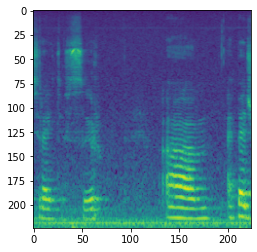

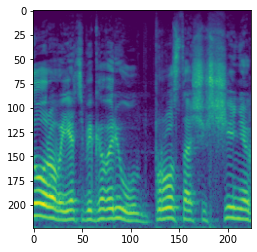

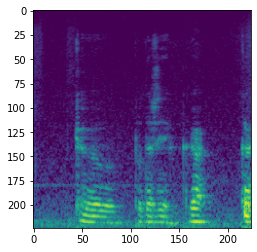

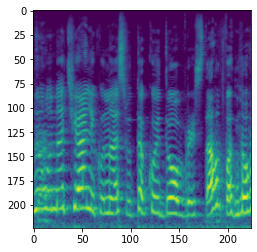

In [4]:
np.random.seed()
for i in np.arange(1, 5):
        n = np.random.randint(1, len(ramas_224_train))
        ax = ramas_224_train.show_image(n)
        plt.show()

# It's learning time!

## 1. Однозадачное обучение IEMOCAP

### 1.1. Без препроцессинга и аугментации

#### AlexNet

In [5]:
# Готовим датасеты, необходим размер 224х224
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [6]:
# Готовим колбэки и девайсы
filename = 'AlexNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
# Используем для обучения и сохранения моделей модуль Skorch [https://skorch.readthedocs.io/en/stable/index.html]
model = md_one.alexnet(num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [8]:
print(filename)
net.fit(train_dataset, y=None)

AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-false.md
  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.3754        1.3435       0.3807        1.3193     +  18.4801
      2       0.3799        1.3197       0.3807        1.3071     +  18.2130
      3       0.4017        1.2884       0.5207        1.1927     +  18.2828
      4       0.5022        1.1479       0.5588        1.0561     +  18.0028
      5       0.5512        1.0679       0.5622        1.0098     +  18.1688
      6       0.5610        1.0499       0.5711        0.9964     +  18.1305
      7       0.5739        1.0349       0.5677        1.0055        18.2098
      8       0.5784        1.0319       0.5812        0.9858     +  18.1964
      9       0.5764        1.0282       0.5890        0.9854     +  18.1918
     10       0.5792        1.0145       0.5901        0.9743     +  18.2508
     11  

     88       0.6685        0.8256       0.6461        0.8782        18.0992
     89       0.6568        0.8396       0.6495        0.8656     +  18.1863
     90       0.6669        0.8286       0.6405        0.8908        18.1069
     91       0.6621        0.8316       0.6484        0.8657        18.0837
     92       0.6702        0.8308       0.6585        0.8646     +  18.1038
     93       0.6635        0.8379       0.6585        0.8632     +  18.0772
     94       0.6663        0.8265       0.6461        0.8626     +  18.1454
     95       0.6674        0.8208       0.6562        0.8554     +  18.0576
     96       0.6643        0.8221       0.6517        0.8569        18.1225
     97       0.6769        0.8190       0.6517        0.8646        18.1093
     98       0.6697        0.8203       0.6461        0.8880        18.1480
     99       0.6697        0.8120       0.6562        0.8790        18.0930
    100       0.6657        0.8176       0.6674        0.8497     +  18.0518

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### VGG-11 с батч-нормализацией

In [9]:
filename = 'VGGNet11--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)

In [10]:
model = md_one.vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [11]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.5006        1.1384       0.5935        0.9888     +  37.9028
      2       0.5750        1.0170       0.6092        0.9491     +  37.9830
      3       0.5871        0.9824       0.6226        0.9368     +  37.9067
      4       0.6100        0.9586       0.6125        0.9258     +  37.9377
      5       0.6179        0.9442       0.6170        0.9328        38.1187
      6       0.6209        0.9338       0.6383        0.8843     +  38.3044
      7       0.6302        0.9071       0.6316        0.8953        38.3357
      8       0.6408        0.8837       0.6103        0.9708        38.5253
      9       0.6484        0.8746       0.5868        1.0375        38.7097
     10       0.6529        0.8552       0.6181        0.8980        38.6059
     11       0.6565        0.8448       0.6092        0.9644        38.5328

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome

#### SER DeepNet

In [19]:
train_dataset = iemocap_64_noprep_train
test_dataset = iemocap_64_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [20]:
filename = 'DeepNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)

In [21]:
model = md_one.PaperCnnDeepNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [22]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.4026        1.3308       0.4670        1.2630     +  3.0970
      2       0.4726        1.2338       0.5039        1.1584     +  3.1080
      3       0.5112        1.1678       0.5409        1.1068     +  3.1166
      4       0.5196        1.1406       0.5588        1.0765     +  3.1194
      5       0.5389        1.1118       0.5588        1.0568     +  3.1263
      6       0.5353        1.0991       0.5622        1.0458     +  3.1222
      7       0.5423        1.0812       0.5756        1.0349     +  3.1395
      8       0.5473        1.0686       0.5733        1.0264     +  3.1388
      9       0.5543        1.0628       0.5767        1.0197     +  3.1365
     10       0.5546        1.0507       0.5845        1.0129     +  3.1261
     11       0.5647        1.0437       0.5789        1.0122     +  3.1350
     12     

     91       0.6540        0.8649       0.6058        0.9335        3.1153
     92       0.6501        0.8792       0.6193        0.9333        3.1171
     93       0.6450        0.8775       0.6092        0.9304     +  3.1168
     94       0.6562        0.8659       0.6069        0.9345        3.1339
     95       0.6543        0.8661       0.6081        0.9328        3.1142
     96       0.6503        0.8711       0.6058        0.9339        3.1019
     97       0.6487        0.8654       0.6137        0.9298     +  3.1065
     98       0.6512        0.8633       0.6137        0.9309        3.1119
     99       0.6657        0.8542       0.6058        0.9292     +  3.0998
    100       0.6601        0.8630       0.6092        0.9279     +  3.1147
    101       0.6433        0.8652       0.6271        0.9289        3.1160
    102       0.6624        0.8582       0.6226        0.9318        3.1046
    103       0.6562        0.8546       0.6271        0.9326        3.1020
    104     

    190       0.6960        0.7766       0.6473        0.9054        3.1165
    191       0.6982        0.7670       0.6394        0.9025        3.1065
    192       0.6904        0.7659       0.6495        0.8987        3.0989
    193       0.6996        0.7690       0.6316        0.9037        3.1024
    194       0.6968        0.7779       0.6383        0.9020        3.0978
    195       0.6954        0.7651       0.6417        0.9091        3.0998
    196       0.6990        0.7740       0.6461        0.9007        3.1077
    197       0.6957        0.7642       0.6439        0.8947     +  3.0951
    198       0.7055        0.7593       0.6506        0.8946     +  3.1202
    199       0.7142        0.7530       0.6495        0.8957        3.1163
    200       0.7002        0.7613       0.6439        0.8935     +  3.1180
    201       0.7013        0.7567       0.6529        0.8961        3.1430
    202       0.7063        0.7565       0.6428        0.8960        3.1088
    203     

    293       0.7349        0.6782       0.6585        0.8967        3.1217
    294       0.7385        0.6877       0.6607        0.8947        3.1253
    295       0.7352        0.6842       0.6596        0.9000        3.1192
    296       0.7382        0.6799       0.6562        0.9013        3.1226
    297       0.7366        0.6907       0.6551        0.9023        3.1141
    298       0.7329        0.6881       0.6461        0.9014        3.0967
    299       0.7388        0.6799       0.6596        0.8919        3.0990
    300       0.7315        0.6824       0.6473        0.8967        3.1004


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnDeepNet(
    (features): Sequential(
      (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (1): ReLU(inplace=True)
      (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (3): ReLU(inplace=True)
      (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (9): ReLU(inplace=True)
      (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running

#### SER StrideNet

In [6]:
train_dataset = iemocap_128_noprep_train
test_dataset = iemocap_128_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [7]:
# Готовим колбэки и девайсы
filename = 'StrideNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [8]:
model = md_one.PaperCnnStrideNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=700, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [9]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.2570        1.3792       0.3807        1.3737     +  5.1025
      2       0.3788        1.3624       0.3807        1.3388     +  4.8541
      3       0.3813        1.3236       0.3807        1.3198     +  4.8364
      4       0.3813        1.3182       0.3807        1.3150     +  4.8271
      5       0.3813        1.3125       0.3807        1.3057     +  4.9010
      6       0.3900        1.2970       0.4311        1.2759     +  4.9127
      7       0.4650        1.2470       0.5118        1.1700     +  4.8768
      8       0.5025        1.1466       0.5140        1.0844     +  4.9218
      9       0.5216        1.1119       0.5274        1.0684     +  4.8643
     10       0.5255        1.0994       0.5622        1.0583     +  4.8643
     11       0.5358        1.0889       0.5532        1.0490     +  4.9179
     12     

     88       0.6086        0.9517       0.6137        0.9272        4.7674
     89       0.6069        0.9564       0.6193        0.9293        4.7766
     90       0.6111        0.9561       0.6114        0.9268        4.7718
     91       0.6069        0.9494       0.6215        0.9237     +  4.7663
     92       0.6117        0.9499       0.6204        0.9258        5.0303
     93       0.6109        0.9516       0.6226        0.9241        4.7697
     94       0.6109        0.9488       0.6170        0.9246        5.0293
     95       0.6086        0.9476       0.6181        0.9237        5.1246
     96       0.6089        0.9502       0.6159        0.9248        5.0517
     97       0.6081        0.9475       0.6204        0.9209     +  5.0556
     98       0.6097        0.9472       0.6170        0.9218        5.0797
     99       0.6148        0.9404       0.6204        0.9206     +  5.0672
    100       0.6170        0.9412       0.6159        0.9226        5.0788
    101     

    188       0.6251        0.9167       0.6282        0.9012     +  5.1003
    189       0.6310        0.9115       0.6204        0.9116        5.0608
    190       0.6355        0.9100       0.6271        0.9047        5.0351
    191       0.6302        0.9159       0.6237        0.9016        5.0343
    192       0.6288        0.9098       0.6327        0.9017        5.0601
    193       0.6274        0.9122       0.6361        0.8992     +  5.0292
    194       0.6338        0.9139       0.6327        0.9018        4.7663
    195       0.6291        0.9158       0.6305        0.9055        4.7608
    196       0.6249        0.9137       0.6271        0.9070        4.7609
    197       0.6293        0.9122       0.6271        0.9037        4.7544
    198       0.6243        0.9125       0.6260        0.9049        4.7630
    199       0.6352        0.9092       0.6249        0.9040        4.7700
    200       0.6263        0.9126       0.6316        0.9003        4.7866
    201     

    291       0.6414        0.8844       0.6417        0.8897        4.8229
    292       0.6391        0.8838       0.6383        0.8917        4.7860
    293       0.6319        0.8852       0.6450        0.8866        4.7950
    294       0.6450        0.8848       0.6428        0.8902        4.7910
    295       0.6417        0.8840       0.6372        0.8899        4.8037
    296       0.6411        0.8799       0.6405        0.8897        4.7970
    297       0.6425        0.8796       0.6450        0.8877        4.8000
    298       0.6411        0.8790       0.6405        0.8848     +  4.7862
    299       0.6459        0.8829       0.6394        0.8852        5.1269
    300       0.6380        0.8874       0.6428        0.8859        5.1219
    301       0.6453        0.8813       0.6439        0.8844     +  5.0903
    302       0.6411        0.8843       0.6405        0.8881        4.8102
    303       0.6380        0.8889       0.6461        0.8853        4.8168
    304     

    394       0.6562        0.8561       0.6517        0.8780        5.0660
    395       0.6501        0.8529       0.6517        0.8742        5.0755
    396       0.6503        0.8635       0.6529        0.8756        5.0861
    397       0.6548        0.8566       0.6484        0.8755        5.0948
    398       0.6554        0.8534       0.6506        0.8844        5.1230
    399       0.6487        0.8578       0.6484        0.8737     +  5.1219
    400       0.6453        0.8582       0.6529        0.8766        4.8084
    401       0.6529        0.8581       0.6495        0.8756        4.7974
    402       0.6551        0.8520       0.6517        0.8724     +  4.7733
    403       0.6543        0.8553       0.6562        0.8781        4.7923
    404       0.6534        0.8523       0.6573        0.8751        4.7709
    405       0.6596        0.8554       0.6551        0.8745        4.7698
    406       0.6478        0.8575       0.6551        0.8723     +  4.7680
    407     

    499       0.6593        0.8331       0.6529        0.8721        4.8176
    500       0.6621        0.8298       0.6607        0.8675        4.8368
    501       0.6565        0.8318       0.6562        0.8654        4.7964
    502       0.6582        0.8281       0.6551        0.8688        4.7863
    503       0.6657        0.8311       0.6529        0.8707        4.8324
    504       0.6582        0.8361       0.6529        0.8734        4.7958
    505       0.6629        0.8321       0.6629        0.8701        4.8320
    506       0.6593        0.8274       0.6551        0.8784        4.8009
    507       0.6635        0.8225       0.6585        0.8706        4.7908
    508       0.6599        0.8284       0.6596        0.8635     +  4.8327
    509       0.6655        0.8262       0.6506        0.8727        4.8115
    510       0.6607        0.8280       0.6506        0.8699        4.7826
    511       0.6638        0.8324       0.6585        0.8636        4.7870
    512     

    604       0.6753        0.8076       0.6450        0.8838        4.7932
    605       0.6719        0.8077       0.6540        0.8619        4.8010
    606       0.6741        0.8027       0.6585        0.8652        4.7939
    607       0.6739        0.8081       0.6573        0.8606        4.7857
    608       0.6705        0.8048       0.6551        0.8608        4.7632
    609       0.6772        0.8012       0.6629        0.8589        4.7595
    610       0.6769        0.7994       0.6562        0.8604        4.7730
    611       0.6775        0.8070       0.6629        0.8585        4.7664
    612       0.6764        0.8030       0.6618        0.8561        4.7611
    613       0.6811        0.7927       0.6641        0.8632        4.7680
    614       0.6739        0.7942       0.6551        0.8642        4.7700
    615       0.6778        0.7951       0.6573        0.8655        4.7895
    616       0.6747        0.7994       0.6652        0.8599        4.7952
    617     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnStrideNet(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (11): ReLU(inplace=True)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (13): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Linear(in_features=1152, out_features=512, bias=True)
      (1): ReLU(inplace=T

### 1.2. Подрубаем препроцессинг

#### AlexNet

In [5]:
train_dataset = iemocap_224_prep_train
test_dataset = iemocap_224_prep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [6]:
filename = 'AlexNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [8]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.3813        1.3413       0.3807        1.3175     +  18.4275
      2       0.3869        1.3051       0.4838        1.2580     +  18.2148
      3       0.4891        1.1739       0.5543        1.0517     +  18.2546
      4       0.5294        1.0998       0.5442        1.0562        18.4036
      5       0.5386        1.0817       0.5711        1.0183     +  18.5258
      6       0.5504        1.0710       0.5812        1.0137     +  18.4981
      7       0.5624        1.0534       0.5834        1.0159        18.4929
      8       0.5577        1.0559       0.5789        1.0121     +  18.4414
      9       0.5655        1.0422       0.5689        1.0042     +  18.4938
     10       0.5750        1.0256       0.5890        0.9873     +  18.3610
     11       0.5728        1.0353       0.6013        0.9752     +  18.4936

     89       0.6741        0.8182       0.6540        0.8747        18.2961
     90       0.6811        0.8130       0.6618        0.8886        18.2423
     91       0.6803        0.8148       0.6540        0.8840        18.1955
     92       0.6806        0.8129       0.6529        0.8731        18.2990
     93       0.6792        0.8137       0.6596        0.8749        18.4315
     94       0.6853        0.8062       0.6495        0.8588     +  18.2184
     95       0.6892        0.8043       0.6439        0.8853        18.4697
     96       0.6769        0.8046       0.6652        0.8594        18.4205
     97       0.6951        0.7901       0.6551        0.8647        18.4754
     98       0.6901        0.7832       0.6585        0.8602        18.4523
     99       0.6892        0.7839       0.6506        0.8956        18.4775
    100       0.6965        0.7780       0.6529        0.8795        18.4752
    101       0.6895        0.7955       0.6450        0.8994        18.3366

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### VGG

In [9]:
filename = 'VggNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [10]:
model = md_one.vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [11]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.5134        1.1307       0.5622        1.0338     +  38.6961
      2       0.5871        1.0156       0.6137        0.9603     +  38.7948
      3       0.5943        0.9836       0.6047        0.9488     +  38.7509
      4       0.6092        0.9609       0.6260        0.9130     +  39.1828
      5       0.6120        0.9499       0.6282        0.9064     +  38.8292
      6       0.6274        0.9319       0.6249        0.9142        38.9176
      7       0.6277        0.9194       0.6349        0.9063     +  39.1262
      8       0.6324        0.9069       0.6506        0.8726     +  39.1059
      9       0.6408        0.8841       0.6417        0.8845        39.3596
     10       0.6425        0.8834       0.6517        0.8874        39.3750
     11       0.6464        0.8762       0.6237        0.9021        39.3575

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome

#### DeepNet

In [12]:
train_dataset = iemocap_64_prep_train
test_dataset = iemocap_64_prep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [13]:
filename = 'DeepNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [14]:
model = md_one.PaperCnnDeepNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [15]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3421        1.3421       0.3807        1.2759     +  3.1203
      2       0.4289        1.2310       0.4983        1.1627     +  3.1261
      3       0.5092        1.1518       0.5386        1.1154     +  3.1533
      4       0.5325        1.1184       0.5521        1.0932     +  3.1454
      5       0.5333        1.0999       0.5465        1.0821     +  3.1472
      6       0.5428        1.0903       0.5666        1.0672     +  3.1276
      7       0.5498        1.0724       0.5666        1.0592     +  3.1444
      8       0.5529        1.0676       0.5733        1.0480     +  3.1342
      9       0.5585        1.0572       0.5756        1.0410     +  3.1155
     10       0.5613        1.0519       0.5823        1.0340     +  3.1273
     11       0.5613        1.0503       0.5834        1.0308     +  3.1243
     12     

     88       0.6621        0.8644       0.6170        0.9349     +  3.1397
     89       0.6579        0.8694       0.6170        0.9370        3.1318
     90       0.6559        0.8626       0.6215        0.9331     +  3.1072
     91       0.6571        0.8612       0.6204        0.9319     +  3.1156
     92       0.6506        0.8690       0.6181        0.9343        3.1243
     93       0.6562        0.8678       0.6181        0.9333        3.1057
     94       0.6573        0.8532       0.6181        0.9361        3.1037
     95       0.6579        0.8495       0.6204        0.9385        3.1204
     96       0.6635        0.8566       0.6226        0.9380        3.1070
     97       0.6599        0.8546       0.6069        0.9346        3.1082
     98       0.6601        0.8574       0.6170        0.9350        3.1059
     99       0.6635        0.8509       0.6237        0.9308     +  3.1089
    100       0.6585        0.8568       0.6159        0.9317        3.1281
    101     

    188       0.7083        0.7581       0.6293        0.9239        3.1039
    189       0.7066        0.7511       0.6361        0.9279        3.1162
    190       0.7002        0.7656       0.6417        0.9249        3.1071
    191       0.7030        0.7495       0.6193        0.9239        3.1083
    192       0.7010        0.7632       0.6349        0.9239        3.1055
    193       0.7097        0.7490       0.6249        0.9254        3.1038
    194       0.7100        0.7512       0.6226        0.9237        3.1046
    195       0.7024        0.7522       0.6260        0.9209        3.1054
    196       0.7018        0.7561       0.6305        0.9227        3.1057
    197       0.7058        0.7574       0.6260        0.9279        3.1071
    198       0.7021        0.7515       0.6316        0.9280        3.1088
    199       0.7172        0.7427       0.6237        0.9257        3.1079
    200       0.7125        0.7358       0.6305        0.9308        3.1053
    201     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnDeepNet(
    (features): Sequential(
      (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (1): ReLU(inplace=True)
      (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (3): ReLU(inplace=True)
      (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (9): ReLU(inplace=True)
      (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running

#### StrideNet

In [4]:
train_dataset = iemocap_128_prep_train
test_dataset = iemocap_128_prep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [5]:
filename = 'StrideNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [6]:
model = md_one.PaperCnnStrideNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=700, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [7]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3796        1.3784       0.3807        1.3716     +  5.0097
      2       0.3813        1.3530       0.3807        1.3236     +  4.8468
      3       0.3813        1.3168       0.3807        1.3118     +  4.8667
      4       0.3816        1.3027       0.3807        1.2817     +  4.8713
      5       0.4586        1.2318       0.5062        1.1410     +  4.8742
      6       0.5311        1.1118       0.5420        1.0677     +  4.8768
      7       0.5515        1.0871       0.5756        1.0545     +  4.8594
      8       0.5580        1.0838       0.5700        1.0521     +  4.8180
      9       0.5529        1.0735       0.5666        1.0442     +  4.8333
     10       0.5647        1.0717       0.5689        1.0428     +  4.8528
     11       0.5616        1.0712       0.5677        1.0429        4.8704
     12     

     88       0.6237        0.9477       0.6137        0.9307        4.8852
     89       0.6229        0.9442       0.6170        0.9249     +  4.8437
     90       0.6162        0.9501       0.6249        0.9242     +  4.8756
     91       0.6237        0.9445       0.6148        0.9283        4.8832
     92       0.6243        0.9445       0.6226        0.9253        4.8665
     93       0.6212        0.9421       0.6226        0.9231     +  4.8642
     94       0.6240        0.9393       0.6237        0.9296        4.8489
     95       0.6159        0.9464       0.6125        0.9380        4.8674
     96       0.6249        0.9394       0.6215        0.9219     +  4.8819
     97       0.6173        0.9470       0.6170        0.9329        4.8960
     98       0.6204        0.9388       0.6181        0.9219        4.8921
     99       0.6240        0.9422       0.6193        0.9280        4.8773
    100       0.6277        0.9400       0.6193        0.9231        4.8677
    101     

    190       0.6335        0.9071       0.6260        0.9032     +  4.8558
    191       0.6341        0.9115       0.6282        0.9062        4.8353
    192       0.6349        0.9083       0.6316        0.9068        4.8657
    193       0.6358        0.9083       0.6293        0.9041        4.8791
    194       0.6349        0.9100       0.6226        0.9048        4.8534
    195       0.6369        0.9101       0.6282        0.9051        4.8336
    196       0.6417        0.9025       0.6372        0.9039        4.8376
    197       0.6335        0.9118       0.6327        0.9040        4.8379
    198       0.6361        0.9070       0.6305        0.9016     +  4.8506
    199       0.6389        0.9033       0.6271        0.9032        4.8756
    200       0.6344        0.9045       0.6293        0.9048        4.8494
    201       0.6347        0.9082       0.6282        0.9187        4.8431
    202       0.6405        0.9064       0.6282        0.9020        4.8435
    203     

    294       0.6414        0.8814       0.6473        0.8997        4.8743
    295       0.6417        0.8763       0.6305        0.9134        4.8721
    296       0.6389        0.8840       0.6327        0.8941        4.8956
    297       0.6559        0.8769       0.6372        0.9079        4.8620
    298       0.6433        0.8796       0.6450        0.8991        4.8772
    299       0.6453        0.8759       0.6372        0.8951        4.8736
    300       0.6481        0.8756       0.6450        0.8946        4.8735
    301       0.6417        0.8812       0.6428        0.8952        4.9658
    302       0.6428        0.8836       0.6383        0.8987        4.8493
    303       0.6517        0.8747       0.6361        0.8932     +  4.8426
    304       0.6439        0.8781       0.6372        0.8972        4.8844
    305       0.6428        0.8751       0.6383        0.8971        4.8554
    306       0.6461        0.8782       0.6372        0.9052        4.8553
    307     

    398       0.6520        0.8558       0.6417        0.8980        4.8856
    399       0.6554        0.8526       0.6394        0.8899        4.8868
    400       0.6618        0.8497       0.6439        0.8971        4.8753
    401       0.6635        0.8536       0.6428        0.8934        4.8656
    402       0.6562        0.8527       0.6405        0.8958        4.8523
    403       0.6526        0.8489       0.6439        0.8934        4.8655
    404       0.6554        0.8568       0.6305        0.9061        4.8508
    405       0.6529        0.8522       0.6495        0.8928        4.8660
    406       0.6593        0.8514       0.6439        0.8921        4.8563
    407       0.6596        0.8471       0.6394        0.9039        4.8552
    408       0.6565        0.8555       0.6372        0.8944        4.8507
    409       0.6540        0.8488       0.6473        0.8915        4.8630
    410       0.6596        0.8560       0.6428        0.8919        4.8584
    411     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnStrideNet(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (11): ReLU(inplace=True)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (13): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Linear(in_features=1152, out_features=512, bias=True)
      (1): ReLU(inplace=T

### 1.3. Подрубаем data augmentation (без препроцессинга)

#### AlexNet

In [3]:
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [4]:
filename = 'AlexNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [6]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ]
)

In [7]:
with open('models//best_models//AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-true.md', 'rb') as f:
    net = pickle.load(f)

In [8]:
net.partial_fit(train_dataset, y=None)

     62       0.6400        0.9104       0.6349        0.8924        16.4509
     63       0.6363        0.9090       0.6405        0.9005     +  17.7432
     64       0.6400        0.8979       0.6428        0.8876     +  17.4403
     65       0.6355        0.9142       0.6450        0.8932     +  16.6315
     66       0.6405        0.8967       0.6428        0.8932        18.3564
     67       0.6377        0.9070       0.6473        0.8955     +  17.1815
     68       0.6341        0.8986       0.6349        0.9023        16.2424
     69       0.6347        0.9050       0.6495        0.9023     +  16.1832
     70       0.6433        0.9116       0.6484        0.9005        16.7281
     71       0.6439        0.8933       0.6428        0.9004        16.3925
     72       0.6422        0.9003       0.6461        0.8793        17.0356
     73       0.6375        0.9128       0.6450        0.8868        17.5366
     74       0.6405        0.8908       0.6361        0.9012        16.1465

    161       0.7024        0.7460       0.6663        0.8432        16.1384
    162       0.7046        0.7489       0.6529        0.8642        16.1942
    163       0.7102        0.7431       0.6629        0.8463        16.1479
    164       0.7102        0.7325       0.6708        0.8360        16.1422
    165       0.7088        0.7390       0.6775        0.8068     +  16.1308
    166       0.7069        0.7359       0.6741        0.8198        16.1647
    167       0.7063        0.7409       0.6708        0.8386        16.1441
    168       0.7130        0.7216       0.6596        0.8791        16.3135
    169       0.7041        0.7381       0.6674        0.8226        16.2359
    170       0.7198        0.7231       0.6764        0.8281        16.2181
    171       0.7038        0.7375       0.6663        0.8230        16.1556
    172       0.7189        0.7206       0.6674        0.8198        16.1901
    173       0.7147        0.7212       0.6652        0.8223        16.0461

    263       0.8091        0.5053       0.6764        0.9447        16.4497
    264       0.8043        0.5110       0.6730        0.9215        16.1559
    265       0.8133        0.5001       0.6775        0.9165        16.1193
    266       0.8088        0.4904       0.6495        0.9638        16.2757
    267       0.8108        0.4831       0.6797        0.9056        16.2532
    268       0.8082        0.5022       0.6865        0.9091        16.3063
    269       0.8203        0.4867       0.6820        0.9674        16.2509
    270       0.8091        0.5007       0.6753        0.9065        16.3908
    271       0.8116        0.4957       0.6876        0.9510        16.1902
    272       0.8116        0.4937       0.6652        0.9616        16.2402
    273       0.8205        0.4757       0.6831        0.9417        16.2611
    274       0.8105        0.4897       0.6753        0.8933        16.1849
    275       0.8211        0.4775       0.6461        0.9923        16.1730

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### VGG

In [3]:
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [6]:
filename = 'VggNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=10, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
model = md_one.vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ]
)

In [8]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4728        1.1820       0.5778        1.0197     +  38.3843
      2       0.5445        1.0758       0.6125        0.9791     +  36.1828
      3       0.5697        1.0308       0.5946        0.9894        36.2884
      4       0.5873        1.0044       0.6025        0.9612        36.7006
      5       0.6008        0.9778       0.6092        0.9371        37.2711
      6       0.6053        0.9723       0.6260        0.9080     +  37.8297
      7       0.6072        0.9571       0.6081        0.9328        38.5101
      8       0.6151        0.9455       0.6249        0.9237        37.6155
      9       0.6156        0.9443       0.6137        0.9390        38.8406
     10       0.6296        0.9197       0.6148        0.8977        38.7714
     11       0.6335        0.9021       0.6271        0.9221     +  37.9191

     95       0.9510        0.1440       0.6484        1.6835        39.3898
     96       0.9434        0.1565       0.7032        1.5000        39.2759
     97       0.9356        0.1667       0.6540        2.0185        39.3314
     98       0.9384        0.1641       0.6417        1.6132        39.3989
     99       0.9468        0.1474       0.5476        2.4261        39.3258
    100       0.9482        0.1462       0.6685        2.1137        39.4603
    101       0.9544        0.1307       0.5689        2.5508        39.5077
    102       0.9510        0.1255       0.6853        1.5459        39.2766
    103       0.9462        0.1448       0.6887        1.7591        39.3604
    104       0.9513        0.1377       0.6932        1.7703        39.5603
    105       0.9476        0.1400       0.6853        1.8745        39.4967
    106       0.9552        0.1322       0.6405        1.8433        39.2899
    107       0.9577        0.1242       0.6753        1.6120        39.6923

    199       0.9936        0.0238       0.6775        2.3868        36.9071
    200       0.9947        0.0156       0.6585        2.6877        36.8381
    201       0.9896        0.0312       0.6148        3.6376        37.8878
    202       0.9908        0.0222       0.6887        2.1832        37.0997
    203       0.9894        0.0270       0.6282        3.2376        36.9809
    204       0.9826        0.0508       0.6450        3.0316        36.9463
    205       0.9877        0.0365       0.6954        2.1596        37.0384
    206       0.9905        0.0277       0.6809        2.3326        37.3358
    207       0.9894        0.0314       0.6674        2.5777        37.0788
    208       0.9955        0.0166       0.7156        2.7631        36.9395
    209       0.9894        0.0241       0.6641        3.7835        37.2282
    210       0.9854        0.0423       0.6293        5.3332        37.0290
    211       0.9801        0.0630       0.7189        2.3000        36.9703

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome

#### Глубже = лучше? Попробуем VGG-19 c батч-нормом

In [4]:
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [5]:
filename = 'VggNet-19--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=10, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [6]:
model = md_one.vgg(type=19, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ]
)

In [7]:
net.fit(train_dataset, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4398        1.2229       0.5599        1.0458     +  57.6251
      2       0.5314        1.0820       0.5890        0.9842     +  57.8970
      3       0.5613        1.0380       0.5801        0.9956        57.8111
      4       0.5767        1.0154       0.5957        1.0162     +  58.0739
      5       0.5977        0.9874       0.5722        0.9978        60.4200
      6       0.6005        0.9706       0.6137        0.9331     +  58.1231
      7       0.6050        0.9623       0.5980        0.9393        59.8954
      8       0.6081        0.9502       0.6293        0.9102     +  60.3638
      9       0.6221        0.9239       0.4468        1.3505        58.2023
     10       0.6319        0.9132       0.6293        0.9079        61.1923
     11       0.6389        0.8979       0.6170        0.9704        61.2440

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13)

#### DeepNet

In [4]:
train_dataset = iemocap_64_noprep_train
test_dataset = iemocap_64_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [5]:
filename = 'DeepNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=True, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [6]:
model = md_one.PaperCnnDeepNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=3e-6, max_epochs=1000, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ]
)

In [7]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3813        1.3617       0.3807        1.3520     +  3.2643
      2       0.3813        1.3412       0.3807        1.3242        3.1014
      3       0.3813        1.3169       0.3807        1.2989        3.0850
      4       0.3824        1.2965       0.3841        1.2713     +  3.0812
      5       0.4163        1.2729       0.4546        1.2348     +  3.1044
      6       0.4566        1.2434       0.4849        1.1987     +  3.1093
      7       0.4810        1.2134       0.5364        1.1637     +  3.1143
      8       0.5067        1.1858       0.5666        1.1299     +  3.1043
      9       0.5302        1.1572       0.5677        1.1058     +  3.1149
     10       0.5308        1.1403       0.5666        1.0894        3.0790
     11       0.5409        1.1250       0.5677        1.0769        3.0826
     12     

     92       0.6053        0.9655       0.5980        0.9611        3.0835
     93       0.6047        0.9723       0.6036        0.9572        3.0773
     94       0.5994        0.9743       0.5991        0.9590        3.0718
     95       0.6011        0.9746       0.5957        0.9615        3.0690
     96       0.5963        0.9732       0.6025        0.9627        3.0747
     97       0.6050        0.9666       0.5957        0.9583        3.0837
     98       0.5999        0.9676       0.5980        0.9560        3.0913
     99       0.6047        0.9648       0.6013        0.9594        3.0872
    100       0.6145        0.9608       0.5980        0.9588        3.0862
    101       0.6081        0.9617       0.5957        0.9553        3.0844
    102       0.6123        0.9645       0.5969        0.9584        3.0697
    103       0.6039        0.9675       0.5980        0.9563        3.0700
    104       0.6053        0.9641       0.5935        0.9573        3.0688
    105     

    194       0.6299        0.9077       0.6036        0.9361        3.0752
    195       0.6363        0.9154       0.6081        0.9362        3.0743
    196       0.6274        0.9149       0.6058        0.9396        3.0837
    197       0.6333        0.9069       0.6047        0.9372        3.0873
    198       0.6324        0.9157       0.6103        0.9352     +  3.0778
    199       0.6274        0.9127       0.6013        0.9365        3.1005
    200       0.6335        0.9117       0.6013        0.9395        3.0782
    201       0.6319        0.9064       0.6036        0.9380        3.0770
    202       0.6327        0.8988       0.6047        0.9369        3.0759
    203       0.6291        0.9123       0.6058        0.9344        3.0918
    204       0.6291        0.9098       0.6092        0.9352        3.0865
    205       0.6232        0.9163       0.6148        0.9370     +  3.0865
    206       0.6310        0.9097       0.6092        0.9344        3.1107
    207     

    297       0.6559        0.8701       0.6081        0.9228        3.0743
    298       0.6562        0.8700       0.6103        0.9223        3.0693
    299       0.6498        0.8632       0.6081        0.9249        3.0796
    300       0.6509        0.8688       0.6137        0.9219        3.0839
    301       0.6571        0.8684       0.6058        0.9256        3.1045
    302       0.6517        0.8693       0.6148        0.9204        3.0917
    303       0.6523        0.8718       0.6125        0.9216        3.0897
    304       0.6526        0.8631       0.6069        0.9237        3.0794
    305       0.6400        0.8713       0.6125        0.9229        3.1842
    306       0.6559        0.8654       0.6148        0.9210        3.0706
    307       0.6587        0.8672       0.6148        0.9206        3.0742
    308       0.6526        0.8630       0.6148        0.9205        3.0869
    309       0.6487        0.8670       0.6125        0.9219        3.0861
    310     

    403       0.6635        0.8385       0.6148        0.9168        3.0768
    404       0.6697        0.8335       0.6204        0.9176        3.0898
    405       0.6666        0.8241       0.6125        0.9207        3.0938
    406       0.6660        0.8413       0.6159        0.9183        3.0877
    407       0.6747        0.8237       0.6114        0.9182        3.0935
    408       0.6635        0.8336       0.6148        0.9182        3.0916
    409       0.6688        0.8320       0.6114        0.9203        3.0925
    410       0.6655        0.8328       0.6058        0.9206        3.0920
    411       0.6705        0.8298       0.6193        0.9199        3.1056
    412       0.6674        0.8311       0.6137        0.9193        3.0922
    413       0.6587        0.8349       0.6125        0.9204        3.0747
    414       0.6725        0.8315       0.6125        0.9199        3.0980
    415       0.6705        0.8355       0.6081        0.9200        3.0950
    416     

    509       0.6848        0.7960       0.6181        0.9191        3.1089
    510       0.6923        0.7909       0.6193        0.9210        3.1146
    511       0.6811        0.8131       0.6226        0.9194        3.1019
    512       0.6820        0.8081       0.6204        0.9221        3.0957
    513       0.6876        0.7998       0.6170        0.9215        3.0951
    514       0.6741        0.8152       0.6181        0.9198        3.0972
    515       0.6839        0.8033       0.6170        0.9199        3.1058
    516       0.6834        0.8026       0.6159        0.9239        3.1099
    517       0.6828        0.8054       0.6204        0.9186        3.1120
    518       0.6867        0.7986       0.6226        0.9192        3.1100
    519       0.6904        0.7910       0.6215        0.9183        3.1021
    520       0.6778        0.8085       0.6237        0.9181        3.1122
    521       0.6778        0.8044       0.6181        0.9190        3.1132
    522     

    616       0.6920        0.7826       0.6215        0.9210        3.1121
    617       0.6828        0.7824       0.6193        0.9176        3.0977
    618       0.6915        0.7925       0.6170        0.9220        3.0844
    619       0.6968        0.7736       0.6193        0.9198        3.0924
    620       0.6906        0.7827       0.6181        0.9235        3.1171
    621       0.6946        0.7707       0.6237        0.9222        3.0969
    622       0.6988        0.7672       0.6204        0.9221        3.1089
    623       0.6878        0.7822       0.6170        0.9234        3.1114
    624       0.6918        0.7797       0.6148        0.9231        3.1078
    625       0.6968        0.7580       0.6282        0.9213        3.1181
    626       0.6904        0.7812       0.6137        0.9209        3.1027
    627       0.6999        0.7749       0.6193        0.9202        3.1138
    628       0.6960        0.7726       0.6249        0.9192        3.1052
    629     

    723       0.7041        0.7609       0.6215        0.9171        3.1013
    724       0.7024        0.7592       0.6114        0.9201        3.1110
    725       0.7044        0.7496       0.6215        0.9205        3.1089
    726       0.6929        0.7559       0.6226        0.9196        3.0929
    727       0.7072        0.7496       0.6159        0.9227        3.0874
    728       0.7004        0.7498       0.6271        0.9188        3.0754
    729       0.7060        0.7509       0.6215        0.9217        3.0912
    730       0.7122        0.7540       0.6249        0.9213        3.0983
    731       0.7055        0.7586       0.6260        0.9228        3.0937
    732       0.7044        0.7449       0.6215        0.9218        3.1160
    733       0.7018        0.7511       0.6249        0.9203        3.1141
    734       0.7066        0.7537       0.6204        0.9204        3.1050
    735       0.6946        0.7697       0.6226        0.9203        3.1142
    736     

    830       0.7170        0.7278       0.6193        0.9245        3.0786
    831       0.7086        0.7337       0.6327        0.9187        3.0829
    832       0.7002        0.7442       0.6293        0.9191        3.0830
    833       0.7094        0.7355       0.6249        0.9204        3.0904
    834       0.7128        0.7240       0.6282        0.9182        3.0821
    835       0.7077        0.7441       0.6215        0.9201        3.0866
    836       0.7181        0.7311       0.6305        0.9169        3.0842
    837       0.7100        0.7393       0.6237        0.9215        3.0834
    838       0.7206        0.7294       0.6282        0.9194        3.0840
    839       0.7164        0.7343       0.6237        0.9209        3.0809
    840       0.7111        0.7283       0.6204        0.9211        3.0817
    841       0.7128        0.7328       0.6260        0.9190        3.0880
    842       0.7223        0.7250       0.6249        0.9213        3.0835
    843     

    938       0.7178        0.7235       0.6260        0.9259        3.1094
    939       0.7214        0.7127       0.6316        0.9260        3.0915
    940       0.7206        0.7205       0.6181        0.9248        3.0999
    941       0.7220        0.7153       0.6260        0.9269        3.0944
    942       0.7172        0.7133       0.6226        0.9253        3.0940
    943       0.7237        0.7100       0.6282        0.9231        3.0934
    944       0.7128        0.7174       0.6293        0.9282        3.0920
    945       0.7147        0.7220       0.6305        0.9255        3.0995
    946       0.7259        0.7077       0.6271        0.9231        3.0908
    947       0.7268        0.7140       0.6293        0.9216        3.0937
    948       0.7161        0.7163       0.6260        0.9229        3.0954
    949       0.7251        0.7039       0.6215        0.9242        3.0935
    950       0.7200        0.7139       0.6271        0.9240        3.0964
    951     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnDeepNet(
    (features): Sequential(
      (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (1): ReLU(inplace=True)
      (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (3): ReLU(inplace=True)
      (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (9): ReLU(inplace=True)
      (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running

#### StrideNet

In [8]:
train_dataset = iemocap_128_noprep_train
test_dataset = iemocap_128_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [9]:
filename = 'StrideNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [10]:
model = md_one.PaperCnnStrideNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=700, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [11]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3712        1.3738       0.3807        1.3677     +  4.7163
      2       0.3813        1.3507       0.3807        1.3295     +  4.7301
      3       0.3813        1.3221       0.3807        1.3242     +  4.7436
      4       0.3813        1.3226       0.3807        1.3231     +  4.7788
      5       0.3813        1.3196       0.3807        1.3204     +  4.7628
      6       0.3813        1.3193       0.3807        1.3184     +  4.7395
      7       0.3813        1.3169       0.3807        1.3166     +  4.7657
      8       0.3813        1.3136       0.3807        1.3136     +  4.7554
      9       0.3813        1.3114       0.3807        1.3065     +  4.7725
     10       0.3813        1.3042       0.3807        1.2874     +  4.7511
     11       0.3830        1.2819       0.4110        1.2447     +  4.7470
     12     

     88       0.6100        0.9578       0.6069        0.9355        4.7383
     89       0.6027        0.9589       0.6069        0.9336     +  4.7379
     90       0.6081        0.9554       0.6103        0.9429        4.7576
     91       0.6078        0.9568       0.6036        0.9342        4.7362
     92       0.6081        0.9547       0.6092        0.9396        4.7314
     93       0.6067        0.9539       0.6058        0.9331     +  4.7368
     94       0.6120        0.9506       0.6114        0.9469        4.7584
     95       0.6123        0.9451       0.6103        0.9323     +  4.7231
     96       0.6041        0.9501       0.6047        0.9306     +  4.7247
     97       0.6153        0.9452       0.6137        0.9343        4.7207
     98       0.6103        0.9541       0.6103        0.9309        4.7064
     99       0.6075        0.9474       0.6114        0.9323        4.7148
    100       0.6083        0.9442       0.6103        0.9308        4.7155
    101     

    188       0.6352        0.8943       0.6282        0.9081        4.7661
    189       0.6442        0.8845       0.6237        0.9159        4.7151
    190       0.6369        0.8927       0.6305        0.9142        4.7112
    191       0.6419        0.8926       0.6305        0.9136        4.7160
    192       0.6299        0.8980       0.6271        0.9104        4.6977
    193       0.6380        0.8962       0.6226        0.9100        4.7012
    194       0.6361        0.8877       0.6237        0.9155        4.7024
    195       0.6383        0.8973       0.6249        0.9076        4.7080
    196       0.6389        0.8952       0.6293        0.9067        4.6985
    197       0.6293        0.9019       0.6293        0.9045     +  4.7078
    198       0.6349        0.9001       0.6316        0.9090        4.7131
    199       0.6386        0.8914       0.6293        0.9062        4.7033
    200       0.6335        0.8901       0.6293        0.9139        4.7138
    201     

    292       0.6461        0.8770       0.6372        0.8968        4.7187
    293       0.6543        0.8662       0.6405        0.8973        4.7308
    294       0.6453        0.8690       0.6405        0.8953     +  4.7482
    295       0.6470        0.8638       0.6338        0.9038        4.7485
    296       0.6503        0.8640       0.6338        0.8968        4.7278
    297       0.6450        0.8679       0.6372        0.8978        4.7519
    298       0.6534        0.8628       0.6327        0.9028        4.7355
    299       0.6461        0.8760       0.6417        0.8947     +  4.7444
    300       0.6498        0.8697       0.6372        0.8956        4.7522
    301       0.6442        0.8627       0.6282        0.8979        4.7300
    302       0.6431        0.8693       0.6405        0.8964        4.7941
    303       0.6453        0.8706       0.6450        0.8932     +  4.7021
    304       0.6456        0.8602       0.6417        0.8977        4.7428
    305     

    395       0.6610        0.8409       0.6529        0.8879        4.7387
    396       0.6520        0.8461       0.6473        0.8849     +  4.7379
    397       0.6557        0.8432       0.6495        0.8853        4.7338
    398       0.6601        0.8427       0.6517        0.8858        4.7642
    399       0.6554        0.8388       0.6439        0.8951        4.7356
    400       0.6517        0.8410       0.6461        0.8917        4.7125
    401       0.6531        0.8444       0.6428        0.8966        4.7276
    402       0.6498        0.8450       0.6517        0.8883        4.7232
    403       0.6582        0.8426       0.6461        0.8861        4.7414
    404       0.6548        0.8455       0.6405        0.8872        4.7384
    405       0.6565        0.8391       0.6495        0.8912        4.7311
    406       0.6585        0.8309       0.6338        0.8923        4.7249
    407       0.6551        0.8374       0.6484        0.8871        4.7207
    408     

    500       0.6677        0.8280       0.6596        0.8759        4.7451
    501       0.6725        0.8184       0.6506        0.8829        4.7528
    502       0.6674        0.8099       0.6562        0.8743     +  4.7417
    503       0.6736        0.8164       0.6461        0.8815        4.7566
    504       0.6671        0.8224       0.6585        0.8758        4.7227
    505       0.6683        0.8148       0.6585        0.8761        4.7362
    506       0.6694        0.8120       0.6540        0.8857        4.7419
    507       0.6730        0.8168       0.6607        0.8751        4.7379
    508       0.6694        0.8116       0.6540        0.8837        4.7460
    509       0.6621        0.8192       0.6517        0.8767        4.7436
    510       0.6624        0.8221       0.6573        0.8741     +  4.7395
    511       0.6694        0.8151       0.6540        0.8904        4.7435
    512       0.6711        0.8135       0.6517        0.8887        4.7312
    513     

    605       0.6851        0.7907       0.6585        0.8748        4.7304
    606       0.6733        0.8018       0.6529        0.8847        4.7315
    607       0.6797        0.7884       0.6573        0.8703        4.7450
    608       0.6778        0.7930       0.6618        0.8671        4.7182
    609       0.6834        0.7892       0.6629        0.8699        4.7154
    610       0.6767        0.8003       0.6618        0.8674        4.7427
    611       0.6851        0.7887       0.6484        0.8715        4.7056
    612       0.6727        0.7933       0.6618        0.8698        4.7255
    613       0.6669        0.8147       0.6529        0.8668        4.7246
    614       0.6792        0.7931       0.6585        0.8776        4.7243
    615       0.6823        0.7969       0.6562        0.8728        4.7442
    616       0.6786        0.7889       0.6585        0.8753        4.7459
    617       0.6769        0.8018       0.6517        0.8786        4.7643
    618     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnStrideNet(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (11): ReLU(inplace=True)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (13): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Linear(in_features=1152, out_features=512, bias=True)
      (1): ReLU(inplace=T

#### ResNet

In [3]:
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [5]:
filename = 'ResNet50--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [6]:
model = md_one.resnet50(pretrained=False, progress=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ]
)

In [7]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4499        1.1999       0.5162        1.0943     +  36.0019
      2       0.5014        1.1303       0.5375        1.0829     +  35.8330
      3       0.5151        1.1190       0.5420        1.0763     +  35.7197
      4       0.5316        1.1025       0.5532        1.0656     +  36.7908
      5       0.5188        1.1005       0.5274        1.0743        35.8556
      6       0.5342        1.0939       0.5498        1.0547     +  35.9195
      7       0.5272        1.0805       0.5711        1.0432     +  36.3652
      8       0.5333        1.0784       0.5644        1.0447        36.4674
      9       0.5398        1.0752       0.5655        1.0506        37.0271
     10       0.5403        1.0650       0.5487        1.0624        36.7148
     11       0.5487        1.0595       0.5577        1.0402     +  36.6337

     90       0.6596        0.8348       0.6237        0.9121        36.4102
     91       0.6571        0.8383       0.6484        0.8865        36.4871
     92       0.6601        0.8452       0.6450        0.8920        36.4880
     93       0.6562        0.8442       0.6338        0.8905        36.5851
     94       0.6610        0.8346       0.6282        0.8786        36.6266
     95       0.6685        0.8327       0.6193        0.9111        36.5143
     96       0.6719        0.8237       0.6249        0.9053        36.4297
     97       0.6495        0.8501       0.6316        0.8782        36.4806
     98       0.6641        0.8257       0.6450        0.8757        36.5519
     99       0.6778        0.8107       0.6439        0.8816        36.5008
    100       0.6702        0.8206       0.6349        0.9018        36.7259
    101       0.6713        0.8146       0.6461        0.8930        36.3799
    102       0.6663        0.8147       0.6282        0.9173        36.5608

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

### 1.4. Аугментация + препроцессинг

#### AlexNet

In [5]:
train_dataset = iemocap_224_prep_train
test_dataset = iemocap_224_prep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [6]:
filename = 'AlexNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [8]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.3659        1.3441       0.3807        1.3200     +  16.2958
      2       0.3819        1.3235       0.3807        1.3114     +  15.9415
      3       0.3849        1.3170       0.3863        1.2734     +  16.4561
      4       0.4583        1.2266       0.5286        1.0699     +  17.7500
      5       0.5154        1.1332       0.5095        1.0784        17.8950
      6       0.5235        1.1027       0.5498        1.0400     +  18.5694
      7       0.5283        1.0950       0.5566        1.0442        18.8195
      8       0.5364        1.0782       0.5700        1.0176     +  18.4979
      9       0.5384        1.0725       0.5845        1.0042     +  18.0143
     10       0.5588        1.0533       0.5756        0.9946     +  18.9647
     11       0.5616        1.0610       0.5722        1.0147        18.8279

     89       0.6649        0.8479       0.6573        0.8725     +  16.3865
     90       0.6638        0.8499       0.6461        0.8782        18.5171
     91       0.6725        0.8489       0.6473        0.8719     +  17.1537
     92       0.6683        0.8460       0.6596        0.8769        18.9636
     93       0.6688        0.8475       0.6540        0.8744        17.0829
     94       0.6680        0.8458       0.6551        0.8858        18.8110
     95       0.6697        0.8400       0.6417        0.8847        18.2935
     96       0.6775        0.8309       0.6607        0.8771        18.9534
     97       0.6750        0.8213       0.6596        0.8875        17.0506
     98       0.6652        0.8431       0.6562        0.8915        18.1263
     99       0.6722        0.8331       0.6428        0.8966        17.1497
    100       0.6739        0.8167       0.6506        0.8673     +  17.4865
    101       0.6867        0.8210       0.6495        0.8917        18.2836

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### VGG

In [9]:
train_dataset = iemocap_224_prep_train
test_dataset = iemocap_224_prep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [10]:
filename = 'VggNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [11]:
model = md_one.vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [12]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.4726        1.1948       0.5521        1.0681     +  36.3216
      2       0.5470        1.0802       0.5767        1.0109     +  36.8388
      3       0.5817        1.0330       0.5857        0.9814     +  36.2055
      4       0.5971        0.9958       0.6193        0.9351     +  36.3140
      5       0.5999        0.9891       0.5969        0.9734        36.4076
      6       0.6075        0.9653       0.6069        0.9416        36.6062
      7       0.6145        0.9538       0.6159        0.9276     +  36.8680
      8       0.6221        0.9435       0.6338        0.9155     +  36.7133
      9       0.6251        0.9348       0.6461        0.8986     +  36.7029
     10       0.6335        0.9253       0.6484        0.8689     +  36.6371
     11       0.6347        0.9049       0.6237        0.9599        36.6801

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome

#### DeepNet

In [4]:
train_dataset = iemocap_64_prep_train
test_dataset = iemocap_64_prep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [6]:
filename = 'DeepNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=50, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
model = md_one.PaperCnnDeepNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=600, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [8]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3508        1.3385       0.3897        1.2857     +  3.2434
      2       0.4183        1.2661       0.4759        1.2118     +  3.0943
      3       0.4681        1.1950       0.5118        1.1452     +  3.0994
      4       0.5146        1.1443       0.5308        1.1100     +  3.0976
      5       0.5308        1.1138       0.5319        1.0942     +  3.0989
      6       0.5364        1.0996       0.5543        1.0739     +  3.0940
      7       0.5395        1.0871       0.5454        1.0711     +  3.0877
      8       0.5414        1.0794       0.5722        1.0531     +  3.0997
      9       0.5364        1.0768       0.5722        1.0450     +  3.0851
     10       0.5468        1.0678       0.5689        1.0408     +  3.0807
     11       0.5554        1.0598       0.5700        1.0363     +  3.0876
     12     

     90       0.6503        0.8915       0.5946        0.9320        3.0676
     91       0.6321        0.8960       0.6036        0.9403        3.0703
     92       0.6473        0.8902       0.6159        0.9279     +  3.0690
     93       0.6436        0.8848       0.6058        0.9303        3.0901
     94       0.6436        0.8932       0.5969        0.9329        3.0774
     95       0.6408        0.9019       0.6047        0.9329        3.0688
     96       0.6548        0.8858       0.5957        0.9294        3.0749
     97       0.6520        0.8763       0.6125        0.9292        3.0732
     98       0.6445        0.8836       0.6002        0.9305        3.0744
     99       0.6501        0.8633       0.6137        0.9352        3.0703
    100       0.6467        0.8806       0.6025        0.9301        3.0707
    101       0.6562        0.8708       0.6092        0.9373        3.0737
    102       0.6537        0.8785       0.6002        0.9341        3.0765
    103     

    191       0.6892        0.7946       0.6338        0.9128        3.0733
    192       0.6851        0.7978       0.6305        0.9231        3.0705
    193       0.6906        0.7908       0.6316        0.9188        3.0695
    194       0.6778        0.8052       0.6417        0.9135        3.0678
    195       0.6825        0.7944       0.6361        0.9108     +  3.0721
    196       0.6865        0.7907       0.6383        0.9181        3.0853
    197       0.6898        0.7903       0.6338        0.9239        3.0712
    198       0.6892        0.7872       0.6349        0.9162        3.0676
    199       0.6800        0.7958       0.6349        0.9175        3.0695
    200       0.6839        0.7976       0.6372        0.9213        3.0802
    201       0.6873        0.7868       0.6327        0.9143        3.0871
    202       0.6783        0.7971       0.6316        0.9201        3.0885
    203       0.6951        0.7788       0.6305        0.9255        3.0840
    204     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnDeepNet(
    (features): Sequential(
      (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (1): ReLU(inplace=True)
      (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
      (3): ReLU(inplace=True)
      (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (9): ReLU(inplace=True)
      (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running

#### StrideNet

In [12]:
train_dataset = iemocap_128_prep_train
test_dataset = iemocap_128_prep_test
train_dataset.augmentation = True
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [13]:
filename = 'StrideNet--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [14]:
model = md_one.PaperCnnStrideNet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=700, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [15]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.3376        1.3759       0.3807        1.3708     +  4.7416
      2       0.3813        1.3599       0.3807        1.3405     +  4.7112
      3       0.3813        1.3185       0.3807        1.3159     +  4.7303
      4       0.3813        1.3099       0.3807        1.3063     +  4.7862
      5       0.3816        1.2930       0.3807        1.2701     +  4.7347
      6       0.4359        1.2295       0.5476        1.1480     +  4.7265
      7       0.5252        1.1359       0.5364        1.0946     +  4.7209
      8       0.5294        1.1130       0.5521        1.0637     +  4.7279
      9       0.5392        1.1032       0.5543        1.0659        4.7385
     10       0.5367        1.1004       0.5487        1.0705        4.7135
     11       0.5521        1.0840       0.5532        1.0541     +  4.6982
     12     

     90       0.6117        0.9703       0.6137        0.9490        4.6919
     91       0.6103        0.9702       0.6159        0.9523        4.6938
     92       0.6187        0.9685       0.6103        0.9481     +  4.6936
     93       0.6137        0.9666       0.6125        0.9577        4.7400
     94       0.6097        0.9721       0.6114        0.9525        4.7162
     95       0.6103        0.9680       0.6148        0.9515        4.7190
     96       0.6103        0.9640       0.6170        0.9521        4.7126
     97       0.6117        0.9682       0.6193        0.9545        4.7387
     98       0.6125        0.9647       0.6204        0.9555        4.7249
     99       0.6139        0.9623       0.6170        0.9465     +  4.7319
    100       0.6139        0.9628       0.6114        0.9443     +  4.7329
    101       0.6111        0.9640       0.6170        0.9429     +  4.7414
    102       0.6184        0.9571       0.6137        0.9443        4.7470
    103     

    192       0.6299        0.9330       0.6193        0.9212     +  4.6875
    193       0.6293        0.9269       0.6181        0.9273        4.7224
    194       0.6249        0.9303       0.6159        0.9296        4.7191
    195       0.6263        0.9254       0.6204        0.9250        4.6950
    196       0.6302        0.9305       0.6170        0.9214        4.6880
    197       0.6316        0.9325       0.6204        0.9293        4.6943
    198       0.6319        0.9329       0.6114        0.9221        4.7039
    199       0.6302        0.9314       0.6181        0.9198     +  4.6998
    200       0.6352        0.9309       0.6170        0.9243        4.6971
    201       0.6277        0.9318       0.6204        0.9216        4.6923
    202       0.6347        0.9254       0.6137        0.9239        4.7179
    203       0.6277        0.9316       0.6137        0.9224        4.7037
    204       0.6313        0.9235       0.6159        0.9247        4.7132
    205     

    296       0.6319        0.9066       0.6237        0.9110        4.6861
    297       0.6372        0.9027       0.6226        0.9110        4.6948
    298       0.6520        0.9009       0.6271        0.9103        4.6854
    299       0.6369        0.9031       0.6237        0.9180        4.6937
    300       0.6422        0.9051       0.6260        0.9106        4.6844
    301       0.6428        0.9051       0.6260        0.9137        4.6744
    302       0.6344        0.9015       0.6271        0.9173        4.6897
    303       0.6391        0.9090       0.6237        0.9153        4.6874
    304       0.6361        0.9049       0.6226        0.9153        4.6850
    305       0.6417        0.9050       0.6237        0.9086     +  4.6863
    306       0.6436        0.9021       0.6226        0.9081     +  4.7030
    307       0.6447        0.8963       0.6193        0.9154        4.7115
    308       0.6389        0.8949       0.6260        0.9157        4.6871
    309     

    401       0.6450        0.8760       0.6293        0.9060        4.7179
    402       0.6461        0.8779       0.6282        0.9157        4.6927
    403       0.6498        0.8767       0.6305        0.9103        4.7018
    404       0.6554        0.8728       0.6249        0.9060        4.6965
    405       0.6515        0.8741       0.6193        0.9076        4.6999
    406       0.6531        0.8805       0.6249        0.9037     +  4.6991
    407       0.6506        0.8783       0.6249        0.9094        4.7068
    408       0.6554        0.8784       0.6215        0.9052        4.6976
    409       0.6512        0.8782       0.6249        0.9076        4.6916
    410       0.6484        0.8818       0.6249        0.9112        4.6860
    411       0.6467        0.8729       0.6193        0.9027     +  4.7054
    412       0.6470        0.8797       0.6249        0.9036        4.7373
    413       0.6492        0.8767       0.6249        0.9037        4.6857
    414     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PaperCnnStrideNet(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (7): ReLU(inplace=True)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (11): ReLU(inplace=True)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
      (13): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Linear(in_features=1152, out_features=512, bias=True)
      (1): ReLU(inplace=T

## 2. Однозадачное обучение RAMAS.

Аудиофайлы датасета были сегментированы на файлы одинаковой длины (4с), поэтому аугментация в том виде, в котором она реализована на датасете IEMOCAP, бесполезна. <br>
Препроцессинг тоже бесполезен, потому что его основная задача - чистить шум на записях, а записи RAMAS сами по себе достаточно качественные в плане шумности. К тому же, подключение препроцессинга не особо повлияло на качество классификации в случае с IEMOCAP.

### 2.1. Бинарная разметка "Domination - Submission" 

#### AlexNet

In [3]:
train_dataset = ramas_224_train
test_dataset = ramas_224_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [4]:
filename = 'AlexNet__{}.md'.format(train_dataset.name)
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [5]:
model = md_one.alexnet(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=200, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ],
    iterator_train__num_workers=8,
    iterator_train__pin_memory=True
)

In [6]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp       dur
-------  -----------  ------------  -----------  ------------  ----  --------
      1       0.5027        0.6932       0.5108        0.6923     +  105.8559
      2       0.5144        0.6920       0.5108        0.6909        104.8584
      3       0.5126        0.6909       0.5108        0.6895        105.1995
      4       0.5126        0.6896       0.5108        0.6882        105.2441
      5       0.5126        0.6891       0.5108        0.6856        105.8193
      6       0.5126        0.6845       0.5216        0.6772     +  104.2904
      7       0.5710        0.6744       0.7194        0.6584     +  105.9115
      8       0.6601        0.6492       0.7518        0.6092     +  106.9091
      9       0.6511        0.6270       0.6727        0.6141        104.6121
     10       0.6871        0.6111       0.7014        0.5797        104.4345
     11       0.6996        0.5914       0.7230        0.5550   

     90       0.8273        0.3637       0.8417        0.3597        104.8165
     91       0.8426        0.3611       0.8129        0.3860        105.3134
     92       0.8264        0.3714       0.8273        0.3710        104.1696
     93       0.8498        0.3553       0.8417        0.3642        105.7827
     94       0.8345        0.3701       0.8525        0.3708        104.6925
     95       0.8354        0.3558       0.8489        0.3650        105.0053
     96       0.8201        0.3762       0.8417        0.3577        105.2150
     97       0.8372        0.3625       0.8165        0.3823        105.8697
     98       0.8336        0.3478       0.8201        0.3727        104.9310
     99       0.8552        0.3316       0.8381        0.3595        104.6119
    100       0.8480        0.3327       0.8237        0.3682        103.8816
    101       0.8444        0.3323       0.8453        0.3533        104.9778
    102       0.8417        0.3348       0.8489        0.3519   

    190       0.8723        0.2843       0.8201        0.4095        105.2598
    191       0.8885        0.2531       0.8561        0.3877        105.3669
    192       0.8876        0.2392       0.8453        0.4250        104.9161
    193       0.8885        0.2438       0.8201        0.4060        107.2832
    194       0.8759        0.2559       0.8237        0.3811        107.4905
    195       0.9002        0.2268       0.8417        0.3956        107.7429
    196       0.8813        0.2439       0.8489        0.4186        107.0139
    197       0.8723        0.2667       0.8453        0.3888        107.1720
    198       0.8921        0.2439       0.8489        0.3969        106.5258
    199       0.9020        0.2329       0.8525        0.4060        107.3902
    200       0.8813        0.2460       0.8489        0.4015        107.5536


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

### 2.2. Все дискретные категории ('Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad emotion', 'Scared', 'Shame', 'Surprised', 'Tiredness')

#### AlexNet

In [2]:
print(RAMAS_PATH_TO_WAVS_DESCRETE)

/media/aggr/DATA/RAMAS/RAMAS/Data/Audio/cut_and_labeled/descrete_labels/segmented/


In [18]:
train_dataset = RamasDataset(
    wavs_path=RAMAS_PATH_TO_WAVS_DESCRETE, base_name='RAMAS_descrete',  # Тренировочный
    spectrogram_shape=224,
    augmentation=False, padding='zero', mode='train', tasks='emotion', 
    emotions=('Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad emotion', 'Scared', 'Shame', 'Surprised', 'Tiredness')
)
test_dataset = RamasDataset(
    wavs_path=RAMAS_PATH_TO_WAVS_DESCRETE, base_name='RAMAS_descrete',  # Тестовый
    spectrogram_shape=224,
    augmentation=False, padding='zero', mode='test', tasks='emotion', 
    emotions=('Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad emotion', 'Scared', 'Shame', 'Surprised', 'Tiredness')
)

============= INITIALIZING DATASET RAMAS_descrete_224_train ===============
============================ SUCCESS! =========================
============= INITIALIZING DATASET RAMAS_descrete_224_test ===============
============================ SUCCESS! =========================


In [21]:
print(len(train_dataset))
print(len(test_dataset))
print(len(test_dataset) / len(train_dataset))

61193
15301
0.25004493978069386


In [4]:
filename = 'AlexNet__{}.md'.format(train_dataset.name)
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
model = md_one.alexnet(num_classes=9)
# device = torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=300, batch_size=128, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ],
    iterator_train__num_workers=5,
    iterator_train__pin_memory=True
)

In [9]:
net.fit(train_dataset, None)

Re-initializing optimizer.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

#### !Нужно менять learning rate, иначе это навечно

In [11]:
with open('models/best_models/AlexNet__RAMAS_descrete_224_train.md', 'rb') as f:
    net = pickle.load(f)

In [14]:
net.lr = 0.01
net.batch_size = 32

In [15]:
net.partial_fit(train_dataset, y=None)

/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=49
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=49
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1563
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=163
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=481
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft

     34       0.3298        1.6882       0.3302        1.6887        2380.8062


/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=659
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=374
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=616
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=395
  warnings.warn(
/home/aggr/ryabinov_project_files/SER_neuro/datasets/ramas.py:14: RuntimeWarning: invalid value encountered in true_divide
  X_std = (X - X.min()) / (X.max() - X.min())
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is

     35       0.3344        1.6727       0.3314        1.6621        2462.2098


/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=163
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=416
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=818
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1563
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=650
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_f

     36       0.3300        1.6785       0.3258        1.6966        2437.7164


/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=744
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=49
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=264
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=650
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=133
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft

     37       0.3304        1.6830       0.3319        1.6868        2456.0290


/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=40
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1083
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=818
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1256
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft

     38       0.3314        1.6819       0.3297        1.6959        2451.1102


/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1815
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=462
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=40
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1140
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=659
  warnings.warn(
/home/aggr/anaconda3/envs/ryabinov/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_f

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

### 2.3. Ekman's "Big Six" (Anger, Happines, Neutral, Sadness, Disgust, Fear)

In [26]:
train_dataset = RamasDataset(
    wavs_path=RAMAS_PATH_TO_WAVS_DESCRETE, base_name='RAMAS_ekman',  # Тренировочный
    spectrogram_shape=224,
    augmentation=False, padding='zero', mode='train', tasks='emotion', 
    emotions=('Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad emotion', 'Scared')
)
test_dataset = RamasDataset(
    wavs_path=RAMAS_PATH_TO_WAVS_DESCRETE, base_name='RAMAS_ekman',  # Тестовый
    spectrogram_shape=224,
    augmentation=False, padding='zero', mode='test', tasks='emotion', 
    emotions=('Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad emotion', 'Scared')
)

============= INITIALIZING DATASET RAMAS_ekman_224_train ===============
============================ SUCCESS! =========================
============= INITIALIZING DATASET RAMAS_ekman_224_test ===============
============================ SUCCESS! =========================


In [27]:
print(len(train_dataset))
print(len(test_dataset))
print(len(test_dataset) / len(train_dataset))

50201
12553
0.25005477978526325


In [28]:
filename = 'AlexNet__{}.md'.format(train_dataset.name)
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_acc_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=15, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [31]:
model = md_one.alexnet(num_classes=6)
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
#         callback_early_stop
    ],
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True
)

In [33]:
net.partial_fit(train_dataset, None)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential